# Import Library yang dipakai

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from io import StringIO
import pickle
import random
import re
import string
import csv
import requests
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load dataset

In [3]:
df = pd.read_csv("data/ulasan.csv")

In [4]:
df.head(3).T

,0,1,2
replyContent,"Pemain yang terhormat,\nKami sangat senang men...",Hi pemain! Kami sepenuhnya memahami perasaan A...,NaN
score,3,5,4
thumbsUpCount,58,415,16
appVersion,3.7.0,3.7.0,3.7.0
content,Mungkin alasan dev-game meluncurkan event even...,Saya rasa PUBG dulu Lebih baik dari yang sekar...,Ada beberapa yang perlu dikoreksi dari segi uk...
repliedAt,2025-04-05 10:05:41,2025-04-05 09:57:00,NaN
reviewCreatedVersion,3.7.0,3.7.0,3.7.0
userImage,https://play-lh.googleusercontent.com/a/ACg8oc...,https://play-lh.googleusercontent.com/a-/ALV-U...,https://play-lh.googleusercontent.com/a/ACg8oc...
userName,Bimo Saputra,Rufy Hermawan,Anwar Sofyan
reviewId,155e9195-495b-4517-9c46-186727a42f2a,b7f48138-da4d-4d03-9d3b-2edd04d1ecd4,b29a7057-b121-4698-8606-e9da7b28f1d3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   replyContent          6111 non-null   object
 1   score                 15000 non-null  int64 
 2   thumbsUpCount         15000 non-null  int64 
 3   appVersion            11428 non-null  object
 4   content               15000 non-null  object
 5   repliedAt             6111 non-null   object
 6   reviewCreatedVersion  11428 non-null  object
 7   userImage             15000 non-null  object
 8   userName              15000 non-null  object
 9   reviewId              15000 non-null  object
 10  at                    15000 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


terdapat beberapa nilai kosong untuk itu perlu kita atasi

# Data preprocessing

##### Gunakan modus (mode) untuk kolom kategori / object untuk mengisi kolom tidak berguna

In [6]:
# Import mode dari statistics
from statistics import mode

# Mengisi kolom object dengan modus (nilai yang paling sering muncul)
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].fillna(df['reviewCreatedVersion'].mode()[0])
df['appVersion'] = df['appVersion'].fillna(df['appVersion'].mode()[0])
df['replyContent'] = df['replyContent'].fillna(df['replyContent'].mode()[0])
df['repliedAt'] = df['repliedAt'].fillna(df['repliedAt'].mode()[0])


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   replyContent          15000 non-null  object
 1   score                 15000 non-null  int64 
 2   thumbsUpCount         15000 non-null  int64 
 3   appVersion            15000 non-null  object
 4   content               15000 non-null  object
 5   repliedAt             15000 non-null  object
 6   reviewCreatedVersion  15000 non-null  object
 7   userImage             15000 non-null  object
 8   userName              15000 non-null  object
 9   reviewId              15000 non-null  object
 10  at                    15000 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [8]:
df.isnull().sum()

replyContent            0
score                   0
thumbsUpCount           0
appVersion              0
content                 0
repliedAt               0
reviewCreatedVersion    0
userImage               0
userName                0
reviewId                0
at                      0
dtype: int64

In [9]:
print(f"missing values: {df.isnull().sum().sum()}")

missing values: 0


In [10]:
print(f"Data duplikat: {df.duplicated().sum()}")

Data duplikat: 0


## Pembersihan teks

In [11]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Remove hashtags
    text = re.sub(r'RT[\s]', '', text)         # Remove RT
    text = re.sub(r"http\S+", '', text)        # Remove links
    text = re.sub(r'[0-9]+', '', text)         # Remove numbers
    text = re.sub(r'\.+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)        # Remove special characters
    text = text.replace('\n', ' ')             # Replace new line into space
    text = text.strip()                        # Trim spaces from both sides
    return text

def casefoldingText(text):  # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text):  # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text):  # Remove stopwords in a text
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update([
        'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya', 'gaa', 'loh',
        'kah', 'woi', 'woii', 'woy', 'dong', 'nih', 'oke', 'eh', 'oh', 'sama', 'buat',
        'aku', 'kamu', 'anda', 'lagi', 'juga', 'tak', 'boleh', 'udah', 'tuh', 'lah', 'kan',
        'coba', 'kayak', 'saya', 'sekali', 'gitu', 'terus', 'bakal', 'aja', 'emang',
        'banget', 'tentu', 'biar', 'jadi', 'begitu', 'baru', 'apaan', 'deh', 'dong',
        'dah', 'malah', 'emg', 'wkwk', 'wkwkwk', 'haha', 'hahaha', 'hadeh', 'aduh',
        'ampun', 'weleh', 'cih', 'buset', 'serius', 'makasih', 'makasi', 'terimakasih',
        'trims', 'thanks', 'tq', 'yuk', 'ayo', 'udh', 'jg', 'aj', 'blm', 'udh', 'krn',
        'dgn', 'dr', 'utk', 'sm', 'pd', 'lg', 'tp', 'tdk', 'td', 'gt', 'jg', 'jgk', 'trs',
        'bgt', 'sy', 'bisa', 'tidak', 'iya', 'tidak', 'boleh', 'mau', 'punya', 'pun',
        'ntar', 'dulu', 'loh', 'dong', 'sih', 'kan', 'nah', 'yaudah', 'ywdh', 'ok', 'btw',
        'gw', 'loe', 'lu', 'gue', 'bro', 'sis', 'bos', 'min', 'admin', 'mantap', 'sip',
        'top', 'mantul', 'parah', 'fix', 'auto', 'anjay', 'anjir', 'njir', 'wih', 'wow',
        'hebat', 'baik', 'buruk', 'jelek', 'bagus', 'bagusan', 'oke', 'okey', 'okay',
        'sipp', 'yes', 'no', 'ya', 'nggak', 'gpp', 'yaelah', 'eluh', 'capek', 'cape',
        'biasa', 'lumayan', 'bgt', 'amat', 'bener', 'beneran'
    ])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):  # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):  # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence


In [12]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal",
              "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong",
              "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha",
              "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak",
              "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa",
              "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik",
              "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu",
              "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget",
              "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung",
              "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan",
              "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana",
              "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan",
              "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar",
              "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng",
              "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong",
              "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak",
              "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi",
              "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa",
              "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri",
              "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci",
              "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok",
              "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor",
              "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik",
              "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan",
              "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu",
              "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana",
              "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi",
              "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak",
              "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back",
              "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa",
              "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa",
              "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi",
              "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana",
              "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya",
              "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya",
              "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he",
              "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus",
              "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka",
              "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja",
              "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga",
              "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara",
              "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi",
              "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu",
              "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya",
              "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala",
              "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah",
              "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan",
              "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau",
              "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya",
              "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat",
              "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor",
              "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran",
              "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat",
              "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan",
              "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa",
              "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan",
              "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta",
              "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu",
              "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu",
              "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin",
              "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman",
              "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak",
              "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa",
              "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ",
              "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini",
              "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku",
              "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan",
              "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah",
              "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri",
              "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini",
              "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti",
              "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil",
              "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic",
              "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar",
              "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri",
              "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah",
              "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah",
              "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah",
              "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", 
              "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti",
              "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor",
              "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika",
              "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus",
              "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa",
              "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara",
              "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok",
              "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih",
              "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian",
              "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat",
              "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi",
              "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah",
              "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi",
              "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan",
              "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", 
              "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", 
              "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", 
              "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", 
              "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah",
              "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", 
              "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", 
              "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", 
              "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", 
              "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", 
              "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", 
              "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", 
              "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", 
              "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", 
              "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas",
              "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan",
              "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum",
              "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis",
              "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau",
              "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung",
              "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh",
              "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki",
              "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa",
              "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep",
              "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang",
              "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek",
              "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur",
              "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu",
              "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya",
              "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak",
              "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah",
              "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat",
              "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi",
              "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", 
              "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik",
              "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak",
              "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak",
              "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan",
              "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur",
              "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih",
              "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan",
              "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak",
              "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus",
              "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok",
              "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena",
              "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya",
              "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan",
              "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat",
              "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum",
              "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat",
              "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main",
              "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan",
              "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin",
              "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta",
              "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing",
              "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa",
              "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", 
              "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", 
              "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", 
              "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", 
              "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", 
              "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", 
              "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", 
              "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram",
              "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", 
              "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", 
              "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", 
              "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti",
              "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa",
              "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap",
              "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", 
              "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV",
              "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah",
              "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung",
              "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend",
              "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik",
              "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya",
              "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu",
              "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman",
              "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling",
              "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut",
              "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu",
              "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang",
              "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap",
              "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend",
              "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "bagu": "bagus",
              "x": "kali"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [13]:
df.head(3).T

,0,1,2
replyContent,"Pemain yang terhormat,\nKami sangat senang men...",Hi pemain! Kami sepenuhnya memahami perasaan A...,"Halo, terima kasih atas umpan balik kamu. Untu..."
score,3,5,4
thumbsUpCount,58,415,16
appVersion,3.7.0,3.7.0,3.7.0
content,Mungkin alasan dev-game meluncurkan event even...,Saya rasa PUBG dulu Lebih baik dari yang sekar...,Ada beberapa yang perlu dikoreksi dari segi uk...
repliedAt,2025-04-05 10:05:41,2025-04-05 09:57:00,2022-05-17 16:05:30
reviewCreatedVersion,3.7.0,3.7.0,3.7.0
userImage,https://play-lh.googleusercontent.com/a/ACg8oc...,https://play-lh.googleusercontent.com/a-/ALV-U...,https://play-lh.googleusercontent.com/a/ACg8oc...
userName,Bimo Saputra,Rufy Hermawan,Anwar Sofyan
reviewId,155e9195-495b-4517-9c46-186727a42f2a,b7f48138-da4d-4d03-9d3b-2edd04d1ecd4,b29a7057-b121-4698-8606-e9da7b28f1d3


In [14]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [15]:
df.head(3)

,replyContent,score,thumbsUpCount,appVersion,content,repliedAt,reviewCreatedVersion,userImage,userName,reviewId,at,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,"Pemain yang terhormat,\nKami sangat senang men...",3,58,3.7.0,Mungkin alasan dev-game meluncurkan event even...,2025-04-05 10:05:41,3.7.0,https://play-lh.googleusercontent.com/a/ACg8oc...,Bimo Saputra,155e9195-495b-4517-9c46-186727a42f2a,2025-04-03 20:14:42,Mungkin alasan devgame meluncurkan event event...,mungkin alasan devgame meluncurkan event event...,mungkin alasan devgame meluncurkan event event...,"[mungkin, alasan, devgame, meluncurkan, event,...","[alasan, devgame, meluncurkan, event, event, g...",alasan devgame meluncurkan event event game va...
1,Hi pemain! Kami sepenuhnya memahami perasaan A...,5,415,3.7.0,Saya rasa PUBG dulu Lebih baik dari yang sekar...,2025-04-05 09:57:00,3.7.0,https://play-lh.googleusercontent.com/a-/ALV-U...,Rufy Hermawan,b7f48138-da4d-4d03-9d3b-2edd04d1ecd4,2025-04-05 10:54:18,Saya rasa PUBG dulu Lebih baik dari yang sekar...,saya rasa pubg dulu lebih baik dari yang sekar...,saya rasa pubg dulu lebih baik dari yang sekar...,"[saya, rasa, pubg, dulu, lebih, baik, dari, ya...","[pubg, berharap, developer, game, mengupdate, ...",pubg berharap developer game mengupdate game b...
2,"Halo, terima kasih atas umpan balik kamu. Untu...",4,16,3.7.0,Ada beberapa yang perlu dikoreksi dari segi uk...,2022-05-17 16:05:30,3.7.0,https://play-lh.googleusercontent.com/a/ACg8oc...,Anwar Sofyan,b29a7057-b121-4698-8606-e9da7b28f1d3,2025-04-05 17:46:21,Ada beberapa yang perlu dikoreksi dari segi uk...,ada beberapa yang perlu dikoreksi dari segi uk...,ada beberapa yang perlu dikoreksi dari segi uk...,"[ada, beberapa, yang, perlu, dikoreksi, dari, ...","[dikoreksi, segi, ukuran, main, kali, handphon...",dikoreksi segi ukuran main kali handphone berk...


# Pelabelan

In [16]:
def fetch_lexicon(url: str) -> dict:
    response = requests.get(url)
    lexicon = {}

    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text))
        for row in reader:
            lexicon[row[0]] = int(row[1])
    else:
        print(f"Gagal mengambil data lexicon dari {url}")

    return lexicon


lexicon_positive = fetch_lexicon(
    'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
)

lexicon_negative = fetch_lexicon(
    'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'
)


In [17]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        score += lexicon_positive.get(word, 0) + lexicon_negative.get(word, 0)
    if score > 1:
        polarity = 'positive'
    elif score == 0:
        polarity = 'neutral'
    else:
        polarity = 'negative'
        
    return score, polarity

In [18]:
# Terapkan fungsi analisis sentimen ke kolom 'text_stopword'
results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)

# Pisahkan hasil menjadi skor dan polaritas
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]

# Tampilkan jumlah masing-masing kategori polaritas
print(df['polarity'].value_counts())


polarity
negative    8192
positive    5827
neutral      981
Name: count, dtype: int64


In [19]:
from sklearn.utils import resample

# Pisahkan data berdasarkan kelas
df_positive = df[df['polarity'] == 'positive']
df_negative = df[df['polarity'] == 'negative']
df_neutral  = df[df['polarity'] == 'neutral']

# Tentukan jumlah sampel target (samakan dengan jumlah data kelas mayoritas)
target_count = df_positive.shape[0]

# Oversample kelas negative
df_negative_upsampled = resample(
    df_negative,
    replace=True,
    n_samples=target_count,
    random_state=42
)

# Oversample kelas neutral
df_neutral_upsampled = resample(
    df_neutral,
    replace=True,
    n_samples=target_count,
    random_state=42
)

# Gabungkan kembali semua data (kelas positive tetap, kelas lain hasil oversampling)
df_balanced = pd.concat([df_positive, df_negative_upsampled, df_neutral_upsampled])

# Acak data agar distribusi merata
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Cek distribusi kelas setelah oversampling
print(df['polarity'].value_counts())


polarity
neutral     5827
positive    5827
negative    5827
Name: count, dtype: int64


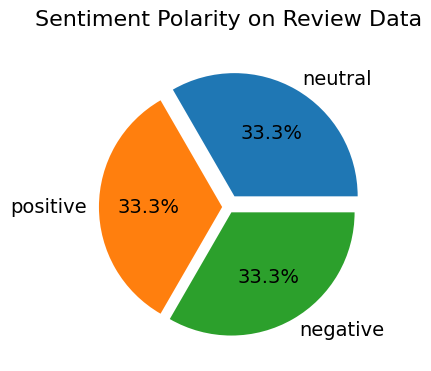

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))
sizes = [count for count in df['polarity'].value_counts()]
labels = list(df['polarity'].value_counts().index)
explode = (0.1, 0.05, 0.05)

ax.pie(
    x=sizes,
    labels=labels,
    autopct='%1.1f%%',
    explode=explode,
    textprops={'fontsize': 14}
)
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)
plt.show()


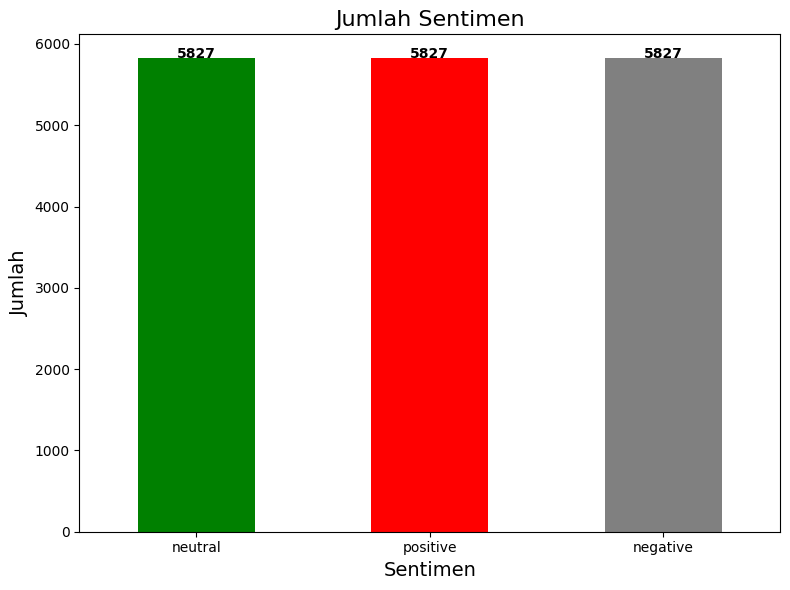

In [21]:
# Membuat bar chart jumlah sentimen
plt.figure(figsize=(8, 6))
df['polarity'].value_counts().plot(kind='bar', color=['green', 'red', 'gray'])

# Menambahkan judul dan label sumbu
plt.title('Jumlah Sentimen', fontsize=16)
plt.xlabel('Sentimen', fontsize=14)
plt.ylabel('Jumlah', fontsize=14)

# Menampilkan angka di atas bar
for i, v in enumerate(df['polarity'].value_counts()):
    plt.text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#### Analisis Ulasan berdasarkan Polaritas dan Visualisasi Word Cloud

In [22]:
def process_reviews(df, polarity, sort_ascending=None, top_n=None):
    """
    Filter, sort, and visualize word cloud for reviews based on polarity.
    """
    pd.set_option('display.max_colwidth', 3000)
    
    # Filter reviews by polarity
    reviews = df.loc[df['polarity'] == polarity, ['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
    
    # Sort if needed
    if sort_ascending is not None:
        reviews = reviews.sort_values('polarity_score', ascending=sort_ascending)

    # Take top N rows if specified
    if top_n:
        reviews = reviews.head(top_n)
    
    reviews = reviews.reset_index(drop=True)
    reviews.index += 1
    
    # Generate word cloud
    list_words = " ".join(word for review in reviews['text_stopword'] for word in review)
    wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
    
    # Plot word cloud
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f'Word Cloud of {polarity.capitalize()} Review Data', fontsize=18)
    ax.imshow(wordcloud)
    ax.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
    return reviews


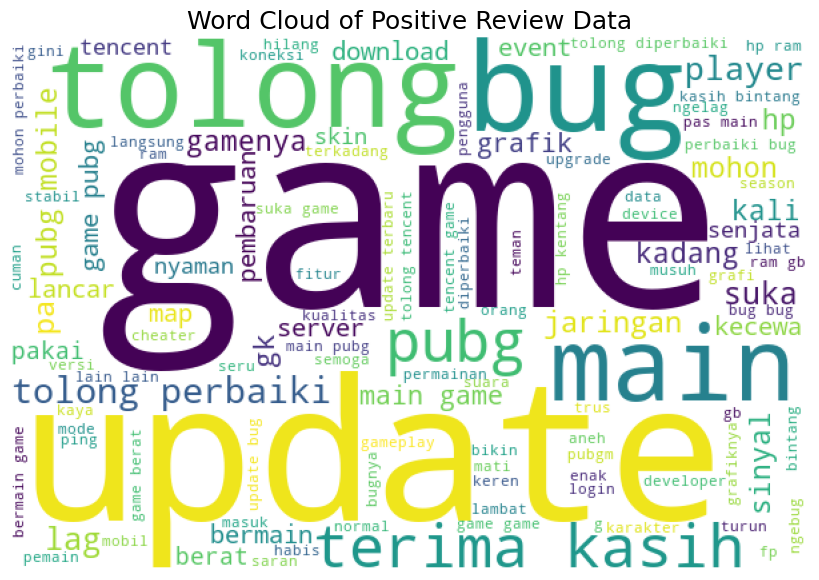

In [23]:
positive_review = process_reviews(df, 'positive')

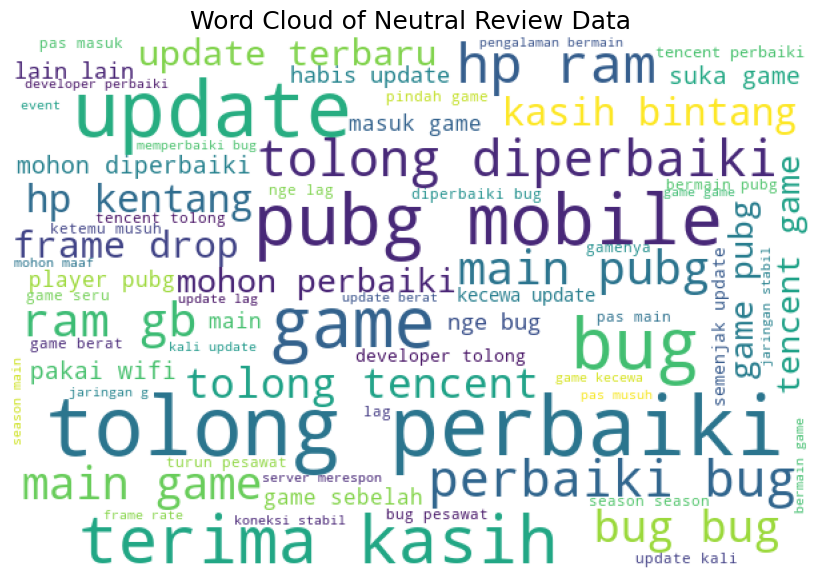

In [24]:
neutral_review = process_reviews(df, 'neutral', sort_ascending=False)

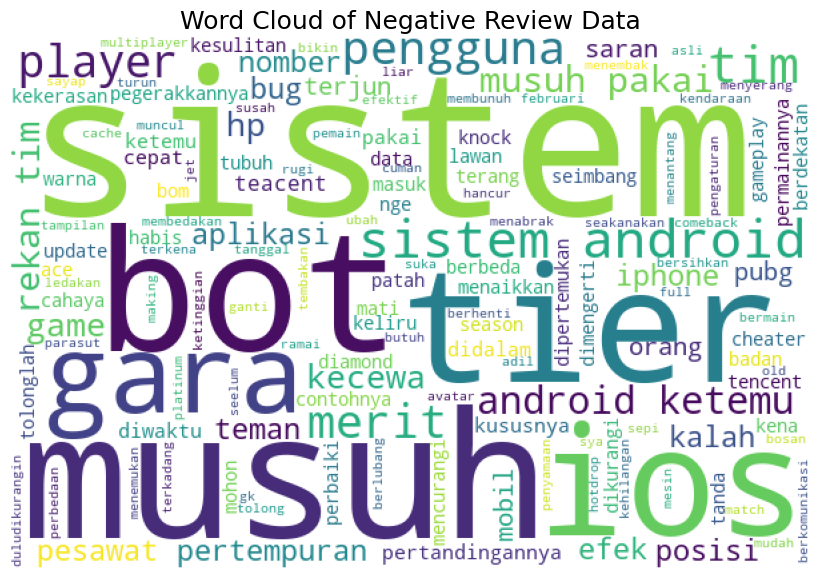

In [25]:
negative_review = process_reviews(df, 'negative', sort_ascending=True, top_n=10)

In [26]:
def show_top_tweets(df, top_n=10):
    """
    Menampilkan top tweet dari masing-masing polaritas berdasarkan skor polaritas.

    Parameter:
    - df: DataFrame yang berisi kolom 'polarity', 'polarity_score', 'text_akhir', dan 'text_stopword'
    - top_n: Jumlah tweet teratas yang ingin ditampilkan per kategori
    """

    # Konfigurasi tampilan panjang kolom
    pd.set_option('display.max_colwidth', 3000)

    # POSITIF
    print("\n🟢 Top Positive Tweets:")
    positive = df[df['polarity'] == 'positive'][['text_akhir', 'polarity_score', 'text_stopword']]
    positive = positive.sort_values(by='polarity_score', ascending=False).reset_index(drop=True)
    display(positive.head(top_n))

    # NEGATIF
    print("\n🔴 Top Negative Tweets:")
    negative = df[df['polarity'] == 'negative'][['text_akhir', 'polarity_score', 'text_stopword']]
    negative = negative.sort_values(by='polarity_score', ascending=True).reset_index(drop=True)
    display(negative.head(top_n))

    # NETRAL
    print("\n🟡 Top Neutral Tweets:")
    neutral = df[df['polarity'] == 'neutral'][['text_akhir', 'polarity_score', 'text_stopword']]
    neutral = neutral.sort_values(by='polarity_score', ascending=False).reset_index(drop=True)
    display(neutral.head(top_n))


In [27]:
show_top_tweets(df, top_n=1)  # Ganti 5 sesuai jumlah yang kamu mau


🟢 Top Positive Tweets:


,text_akhir,polarity_score,text_stopword
0,menilai game pubg bahasa indonesia aspek teknis grafis kualitas visual detail animasi suara kualitas efek suara musik pengalaman audio performa kecepatan responsif stabilitas game aspek desain gameplay keseruan tantangan kepuasan bermain kontrol kemudahan responsifitas pengendalian karakter elemen game cerita kualitas narasi pengembangan karakter kejutan plot,36,"[menilai, game, pubg, bahasa, indonesia, aspek, teknis, grafis, kualitas, visual, detail, animasi, suara, kualitas, efek, suara, musik, pengalaman, audio, performa, kecepatan, responsif, stabilitas, game, aspek, desain, gameplay, keseruan, tantangan, kepuasan, bermain, kontrol, kemudahan, responsifitas, pengendalian, karakter, elemen, game, cerita, kualitas, narasi, pengembangan, karakter, kejutan, plot]"



🔴 Top Negative Tweets:


,text_akhir,polarity_score,text_stopword
0,saran teacent pertandingannya kususnya sistem pengguna android ketemu sistem android sistem ios ketemu sistem ios didalam pertempuran sistem android ketemu musuh pakai sistem ios musuh pakai hp iphone diwaktu pertempuran sistem android kalah cepat pegerakkannya sistem pengguna ios terang pengguna hp sistem android ketemu musuh pakai iphone kalah,-51,"[saran, teacent, pertandingannya, kususnya, sistem, pengguna, android, ketemu, sistem, android, sistem, ios, ketemu, sistem, ios, didalam, pertempuran, sistem, android, ketemu, musuh, pakai, sistem, ios, musuh, pakai, hp, iphone, diwaktu, pertempuran, sistem, android, kalah, cepat, pegerakkannya, sistem, pengguna, ios, terang, pengguna, hp, sistem, android, ketemu, musuh, pakai, iphone, kalah]"



🟡 Top Neutral Tweets:


,text_akhir,polarity_score,text_stopword
0,pubg mobile updatenya kerenkeren sayang hp kentang bermain maksimal pubg mobile mengutamakan kelas elit gensi rekomendasikan teman hp sayauinsatal pubg mobile menemani,0,"[pubg, mobile, updatenya, kerenkeren, sayang, hp, kentang, bermain, maksimal, pubg, mobile, mengutamakan, kelas, elit, gensi, rekomendasikan, teman, hp, sayauinsatal, pubg, mobile, menemani]"


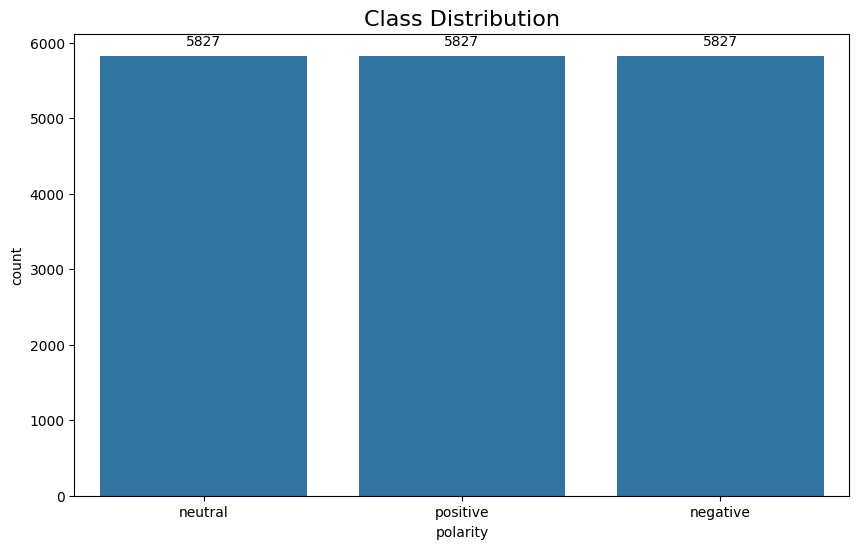

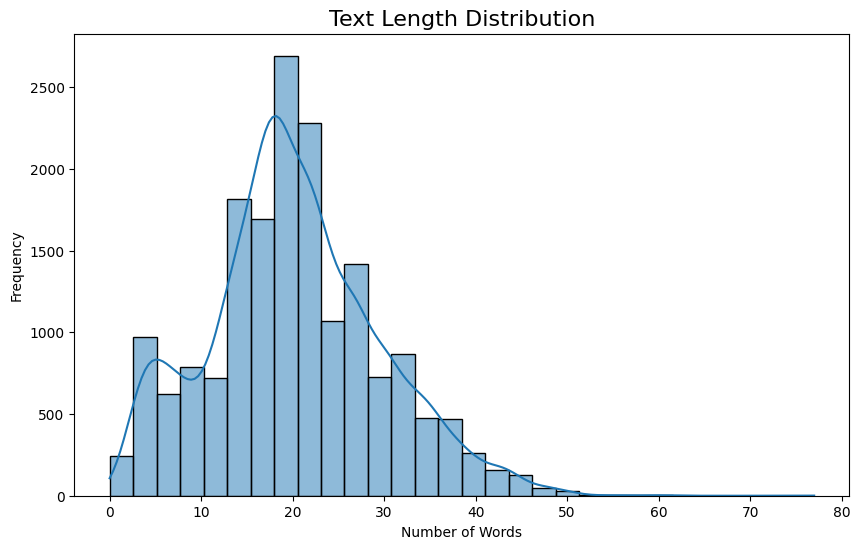

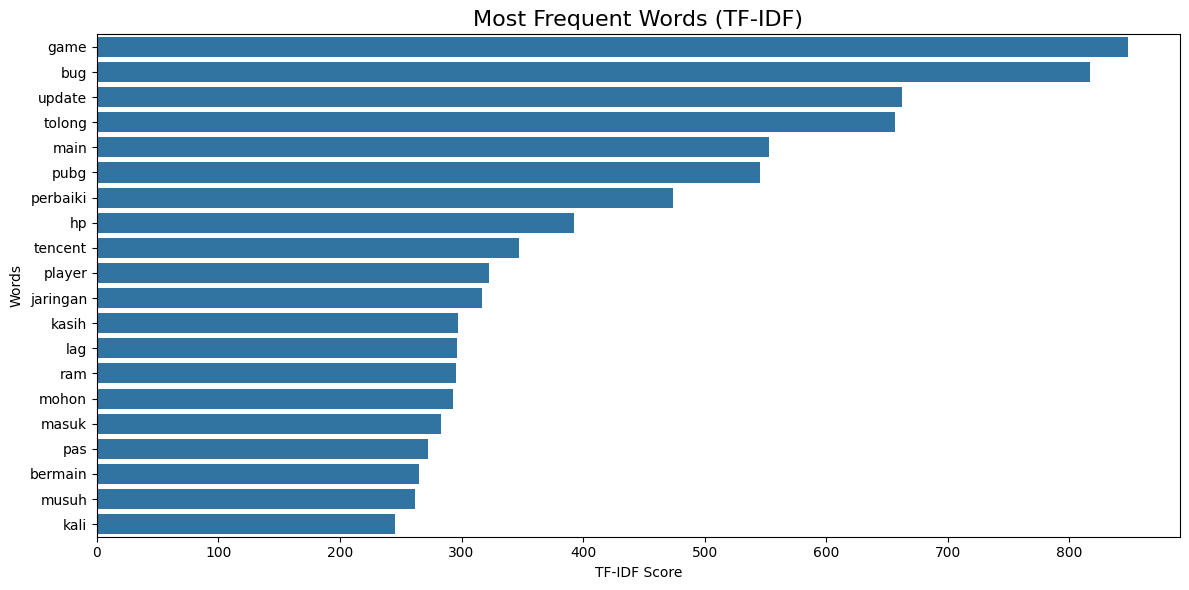

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Visualisasi Distribusi Kelas Sentimen ---

# Mengatur ukuran gambar
plt.figure(figsize=(10, 6))

# Membuat plot distribusi kelas sentimen
class_dist_plot = sns.countplot(x='polarity', data=df)
plt.title('Class Distribution', fontsize=16)

# Menambahkan label jumlah pada setiap bar
for p in class_dist_plot.patches:
    class_dist_plot.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points'
    )

# Menampilkan plot
plt.show()

# --- Visualisasi Distribusi Panjang Teks ---

# Mengatur ukuran gambar
plt.figure(figsize=(10, 6))

# Menambahkan kolom panjang teks
df['text_length'] = df['text_akhir'].apply(lambda x: len(x.split()))

# Membuat histogram panjang teks
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution', fontsize=16)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# --- Visualisasi Kata Paling Sering Muncul (TF-IDF) ---

# Mengatur ukuran gambar
plt.figure(figsize=(12, 6))

# Membuat vektor TF-IDF dari teks akhir
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text_akhir'])

# Mengubah hasil TF-IDF menjadi DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Menjumlahkan skor TF-IDF tiap kata dan memilih 20 kata teratas
tfidf_sum = tfidf_df.sum().reset_index(name='jumlah')
tfidf_sum.columns = ['kata', 'jumlah']
tfidf_top20 = tfidf_sum.sort_values('jumlah', ascending=False).head(20)

# Membuat barplot kata paling sering muncul
sns.barplot(x='jumlah', y='kata', data=tfidf_top20)
plt.title('Most Frequent Words (TF-IDF)', fontsize=16)
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.tight_layout()
plt.show()


# Data Splitting

In [29]:
# Menampilkan 3 baris pertama dan transpose dengan styling 
df.head(3).T

,0,1,2
replyContent,"Halo, terima kasih atas umpan balik kamu. Untuk bantuan cepat tentang masalah seperti komentar, bug dalam game, kesalahan login, lag, crash...tolong kirimkan kami informasi terperinci via PUBGMOBILE_CS@tencentgames.com! Selamat main!","Hello, please ensure the device is not charging and other apps are closed in background. Reduce the display setting to see if it helps. If the issue persists, please contact our customer support team from settings for further assistance with screenshot of error code and more details about your issue.","Halo pemain,\nKami menyesal bahwa Anda memiliki beberapa pengalaman yang tidak menyenangkan. Untuk membantu Anda memecahkan masalah secepat mungkin, silakan berikan kami waktu terjadinya bug dan deskripsi mendetailnya melalui [Pusat Pelanggan] di dalam game, dan kami akan membantu Anda."
score,4,2,1
thumbsUpCount,0,2,18
appVersion,0.9.0,0.13.0,3.5.0
content,"Saya senang sekali dengan gamenya dari grafisnya, gampelaynya semua bagus hanya saya cmn mau blg kalau servernya masih harus lebih di stabilkan lagi dan juga lebih enak kalau kita bisa memakai baju bebas seperti di komputer","Kenapa akhir akhir ini saat permainan sering ngeframe atau lag saat ketemu musuh,hal ini buat ngga nyaman,dan satu tim lag nya barengan terus,mohon di perbaiki ini,padahal HP sudah Snapdragon 660 ,sinyal stabil. Maaf saya kasih bintang 2","pelaporan cheat sudah tidak ada. cheat multiple kevlar, multiple helmet, multiple respawn, no reload tidak bisa dilaporkan. pilihan untuk melapor juga tidak muncul. bug tembus tembok, batu, dan pohon dibiarkan. sudah sangat tidak nyaman untuk dimainkan (kecuali pertandingan turnamen offline)."
repliedAt,2022-05-17 16:05:30,2019-12-08 16:09:18,2024-12-01 15:29:22
reviewCreatedVersion,0.9.0,0.13.0,3.5.0
userImage,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,https://play-lh.googleusercontent.com/a-/ALV-UjXZ4VzwJ1l5OUGGaIqjgVr4zMV6zV6KpcDpcvMZ4h7N5P3muc4
userName,Pengguna Google,Pengguna Google,UcinX NotZ SphinX (miaw)
reviewId,b8852a6e-1113-40c8-8d77-40a04e3b2f61,a75a625d-20e1-4171-91b6-10928c1fcfd6,255b6db4-5081-4783-bf13-8cf389e3008c


In [30]:
# Memisahkan data fitur dan label
X = df['text_akhir']
y = df['polarity']

# Langkah pertama: bagi data menjadi 80% untuk train+validasi, dan 20% untuk test
X_trainval_raw, X_test_raw, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Dari 80% data tadi, kita ambil 75% untuk training dan 25% untuk validasi
# (karena 0.25 * 80% = 20%), sehingga totalnya jadi 60:20:20
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_trainval_raw, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)


In [31]:
# Encode label menggunakan LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# One-hot encoding untuk label yang sudah di-encode
y_train_ohe = to_categorical(y_train_encoded)
y_val_ohe = to_categorical(y_val_encoded)
y_test_ohe = to_categorical(y_test_encoded)

# Simpan LabelEncoder ke file
with open("label_encoder.pkl", "wb") as le_file:
    pickle.dump(le, le_file)

In [32]:
def preprocess_data(X_train_raw, X_val_raw, X_test_raw, method='tfidf'):
    """
    Preprocessing data dengan ekstraksi fitur.

    Parameter:
        X_train_raw: Data teks latih (belum diolah).
        X_val_raw  : Data teks validasi (belum diolah).
        X_test_raw : Data teks uji (belum diolah).
        method     : Metode ekstraksi fitur ('tfidf' atau 'count').

    Mengembalikan:
        X_train    : Data fitur latih (sparse matrix).
        X_val      : Data fitur validasi (sparse matrix).
        X_test     : Data fitur uji (sparse matrix).
        vectorizer : Objek vectorizer yang telah di-fit.
    """
    if method == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=500, min_df=15, max_df=0.9)
        vectorizer_filename = "vectorizer_tfidf.pkl"
        print("vectorizer_tfidf.pkl berhasil disimpan")
    
    elif method == 'count':
        vectorizer = CountVectorizer(max_features=1000, min_df=10, max_df=0.8)
        vectorizer_filename = "vectorizer_count.pkl"
        print("vectorizer_count.pkl berhasil disimpan")
    
    else:
        raise ValueError("Method harus 'tfidf' atau 'count'.")

    # Ekstraksi fitur
    X_train = vectorizer.fit_transform(X_train_raw)
    X_val = vectorizer.transform(X_val_raw)
    X_test = vectorizer.transform(X_test_raw)

    # Simpan vectorizer
    with open(vectorizer_filename, "wb") as vec_file:
        pickle.dump(vectorizer, vec_file)

    return X_train, X_val, X_test, vectorizer


In [33]:
# === Ekstraksi TF-IDF ===
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer = preprocess_data(
    X_train_raw, X_val_raw, X_test_raw, method='tfidf'
)

# === Ekstraksi CountVectorizer ===
X_train_count, X_val_count, X_test_count, count_vectorizer = preprocess_data(
    X_train_raw, X_val_raw, X_test_raw, method='count'
)


vectorizer_tfidf.pkl berhasil disimpan
vectorizer_count.pkl berhasil disimpan


# Pemodelan 

#### Pelatihan Model Neural Network untuk Klasifikasi Sentimen dengan Fitur TF-IDF

In [34]:
# === Membangun Model Neural Network ===
model = Sequential([
    Input(shape=(X_train_tfidf.shape[1],)),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(3, activation='softmax')
])

# === Kompilasi Model ===
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Callback ===
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# === Training Model ===
history = model.fit(
    X_train_tfidf.toarray(), y_train_ohe,
    validation_data=(X_val_tfidf.toarray(), y_val_ohe),
    epochs=40,
    batch_size=64,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

#Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(X_test_tfidf.toarray(), y_test_ohe, verbose=1)

print(f'Akurasi pada test set: {test_accuracy:.4f}')

Epoch 1/40
160/164 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5051 - loss: 1.2356
Epoch 1: val_accuracy improved from -inf to 0.52717, saving model to best_model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5077 - loss: 1.2280 - val_accuracy: 0.5272 - val_loss: 1.0003 - learning_rate: 0.0010
Epoch 2/40
160/164 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8160 - loss: 0.4781
Epoch 2: val_accuracy improved from 0.52717 to 0.61213, saving model to best_model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8164 - loss: 0.4772 - val_accuracy: 0.6121 - val_loss: 0.8404 - learning_rate: 0.0010
Epoch 3/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8916 - loss: 0.2959
Epoch 3: val_accuracy improved from 0.61213 to 0.83038, saving model to best_model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8917 - loss: 0.2957 - val_accuracy: 0.8304 - val_loss: 0.4833 - learning_rate: 0.0010
Epoch 4/40
160/164 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/ste

 #### Pelatihan Model Deep Learning untuk Klasifikasi Sentimen dengan Fitur CountVectorizer

In [35]:
# === ARSITEKTUR MODEL DEEP LEARNING (COUNT) ===
model_count = Sequential([
    Input(shape=(X_train_count.shape[1],)),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(3, activation='softmax')  # Tiga kelas sentimen: positif, negatif, netral
])

# === KOMPILASI MODEL ===
model_count.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === CALLBACKS ===
early_stop_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

checkpoint_cb = ModelCheckpoint(
    'best_model2.keras',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# === TRAINING MODEL ===
history_count = model_count.fit(
    X_train_count.toarray(), y_train_ohe,
    validation_data=(X_val_count.toarray(), y_val_ohe),
    epochs=40,
    batch_size=64,
    callbacks=[early_stop_cb, checkpoint_cb, reduce_lr_cb]
)

#Evaluasi model pada test set
test_loss, test_accuracy = model_count.evaluate(X_test_count.toarray(), y_test_ohe, verbose=1)

print(f'Akurasi pada test set: {test_accuracy:.4f}')

Epoch 1/40
163/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5389 - loss: 1.1487
Epoch 1: val_accuracy improved from -inf to 0.60469, saving model to best_model2.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5399 - loss: 1.1461 - val_accuracy: 0.6047 - val_loss: 0.8410 - learning_rate: 0.0010
Epoch 2/40
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8458 - loss: 0.3998
Epoch 2: val_accuracy improved from 0.60469 to 0.81550, saving model to best_model2.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8463 - loss: 0.3988 - val_accuracy: 0.8155 - val_loss: 0.4961 - learning_rate: 0.0010
Epoch 3/40
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9325 - loss: 0.1921
Epoch 3: val_accuracy improved from 0.81550 to 0.88644, saving model to best_model2.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9327 - loss: 0.1918 - val_accuracy: 0.8864 - val_loss: 0.3512 - learning_rate: 0.0010
Epoch 4/40
162/164 ━━━━━━━━━━━━━━━━━━━━ 0s 13m

#### Model Deep Learning dengan Residual Connection Menggunakan TF-IDF untuk Klasifikasi Sentimen

In [36]:
# === Arsitektur Model dengan Residual Connection (TF-IDF) ===
input_layer = Input(shape=(X_train_tfidf.shape[1],))

# Layer pertama
x = Dense(512, kernel_initializer='he_normal')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Residual block
res = Dense(512, kernel_initializer='he_normal')(x)
res = BatchNormalization()(res)
res = Activation('relu')(res)
res = Dropout(0.3)(res)

# Skip connection
x = Add()([x, res])
x = Activation('relu')(x)

# Layer tambahan
x = Dense(256, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

# Output layer
output_layer = Dense(3, activation='softmax')(x)

# Membangun dan kompilasi model
model3 = Model(inputs=input_layer, outputs=output_layer)
model3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Callbacks ===
early_stop3 = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

checkpoint3 = ModelCheckpoint(
    'best_model3.keras',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

reduce_lr3 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# === Training model ===
history3 = model3.fit(
    X_train_tfidf.toarray(), y_train_ohe,
    validation_data=(X_val_tfidf.toarray(), y_val_ohe),
    epochs=40,
    batch_size=64,
    callbacks=[early_stop3, checkpoint3, reduce_lr3]
)

#Evaluasi model pada test set
test_loss, test_accuracy = model3.evaluate(X_test_tfidf.toarray(), y_test_ohe, verbose=1)

print(f'Akurasi pada test set: {test_accuracy:.4f}')

Epoch 1/40
160/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5155 - loss: 1.0538
Epoch 1: val_accuracy improved from -inf to 0.62243, saving model to best_model3.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5188 - loss: 1.0478 - val_accuracy: 0.6224 - val_loss: 0.9434 - learning_rate: 0.0010
Epoch 2/40
163/164 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8621 - loss: 0.3825
Epoch 2: val_accuracy improved from 0.62243 to 0.69622, saving model to best_model3.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8623 - loss: 0.3820 - val_accuracy: 0.6962 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 3/40
162/164 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9414 - loss: 0.1856
Epoch 3: val_accuracy improved from 0.69622 to 0.84725, saving model to best_model3.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9415 - loss: 0.1852 - val_accuracy: 0.8473 - val_loss: 0.4109 - learning_rate: 0.0010
Epoch 4/40
158/164 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

# data uji /testing

In [37]:
def predict_sentiment(text, model_type='tfidf_simple'):
    """
    Memprediksi sentimen dari teks input untuk 4 model berbeda.

    Parameter:
    - text (str): Teks yang akan diprediksi
    - model_type (str): Jenis model yang ingin digunakan:
        - 'tfidf_simple'    : Model sederhana dengan TF-IDF
        - 'count_simple'    : Model sederhana dengan CountVectorizer
        - 'tfidf_residual'  : Model residual dengan TF-IDF

    Mengembalikan:
    - predicted_class (str): Kelas prediksi (negatif/netral/positif)
    - probabilities (dict): Probabilitas untuk setiap kelas
    """

    # Load vectorizer sesuai jenis model
    if model_type in ['tfidf_simple', 'tfidf_residual']:
        with open('vectorizer_tfidf.pkl', 'rb') as f:
            vectorizer = pickle.load(f)
    elif model_type == 'count_simple':
        with open('vectorizer_count.pkl', 'rb') as f:
            vectorizer = pickle.load(f)
    else:
        raise ValueError("Pilih model_type: 'tfidf_simple', 'count_simple', atau 'tfidf_residual'")

    # Load model sesuai jenis model
    model_paths = {
        'tfidf_simple': 'best_model.keras',
        'count_simple': 'best_model2.keras',
        'tfidf_residual': 'best_model3.keras'
    }
    model = load_model(model_paths[model_type])

    # Load LabelEncoder
    with open('label_encoder.pkl', 'rb') as f:
        le = pickle.load(f)

    # Preprocessing teks
    text_vec = vectorizer.transform([text]).toarray()

    # Prediksi
    prediction = model.predict(text_vec)
    predicted_class_idx = np.argmax(prediction, axis=1)
    predicted_class = le.inverse_transform(predicted_class_idx)[0]

    # Format hasil prediksi
    classes = le.classes_
    probabilities = {cls: float(prob) for cls, prob in zip(classes, prediction[0])}

    return predicted_class, probabilities


In [40]:
sample_texts = [
    "Aplikasi ini JUARA! Saya PUAS dengan update terbaru!",
    "Fitur baru error terus, bikin KESAL!",
    "lumayan."
]

model_types = [
    'tfidf_simple',
    'count_simple',
    'tfidf_residual'
]

random.shuffle(sample_texts)

for text in sample_texts:
    print(f"\n\nText: {text}")
    print("=" * 100)
    for model_type in model_types:
        predicted_class, probabilities = predict_sentiment(text, model_type=model_type)
        print(f"Model: {model_type.upper():<15} | Predicted: {predicted_class:<8} | Probabilities: {probabilities}")




Text: Aplikasi ini JUARA! Saya PUAS dengan update terbaru!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Model: TFIDF_SIMPLE    | Predicted: positive | Probabilities: {'negative': 8.852516089064011e-07, 'neutral': 2.27433665713761e-05, 'positive': 0.999976396560669}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Model: COUNT_SIMPLE    | Predicted: positive | Probabilities: {'negative': 4.184370118309744e-05, 'neutral': 0.00025247709709219635, 'positive': 0.9997056126594543}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Model: TFIDF_RESIDUAL  | Predicted: positive | Probabilities: {'negative': 3.7869929201406194e-06, 'neutral': 0.0006712970789521933, 'positive': 0.9993249177932739}


Text: Fitur baru error terus, bikin KESAL!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Model: TFIDF_SIMPLE    | Predicted: negative | Probabilities: {'negative': 0.9999792575836182, 'neutral': 2.0783845684491098e-05, 'positive': 3.6605349862384173e-08}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Model: COUNT_SIMPLE    | Predicted: negat